In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Регрессия

In [2]:
train_reg = pd.read_csv('Регрессия/train.csv')
test_reg = pd.read_csv('Регрессия/test.csv')

In [3]:
target_reg = 'mean_exam_points'

train_x_reg = train_reg.drop([target_reg, 'Id'], axis=1).to_numpy()
train_y_reg = train_reg[target_reg].to_numpy()

test_reg = test_reg.drop('Id', axis=1).to_numpy()

In [4]:
x_train_reg, x_valid_reg, y_train_reg, y_valid_reg = train_test_split(train_x_reg, train_y_reg, test_size=0.25)

In [5]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [6]:
class LeafRegressor:
    
    def __init__(self, data, values):
        self.data = data
        self.values = values
        self.prediction = np.mean(self.values)

In [7]:
class TreeRegressor:

    def __init__(self, max_depth, min_leaf, n_features, random_seed):
        self.max_depth = max_depth
        self.min_leaf = min_leaf
        self.n_features = n_features
        self.random_seed = random_seed
        self.tree = None

    def quality(self, left_values, right_values, current_dispersion):
        p = float(left_values.shape[0]) / (left_values.shape[0] + right_values.shape[0])
        return current_dispersion - p * np.std(left_values) - (1 - p) * np.std(right_values)

    def split(self, data, values_, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        
        true_data = data[left]
        false_data = data[right]
        true_values = values_[left]
        false_values = values_[right]
        
        return true_data, false_data, true_values, false_values

    def find_best_split(self, data, values_):
        current_dispersion = np.std(values_)
        best_quality = 0
        best_t = None
        best_index = None
        
        if self.n_features and self.n_features < data.shape[1]:
            np.random.seed(self.random_seed)
            idx_features = np.random.choice(range(data.shape[1]), self.n_features, replace=False)               
        else:
            idx_features = range(data.shape[1])

        for idx in idx_features:
            t_values = np.unique([row[idx] for row in data])
      
            for t in t_values:
                true_data, false_data, true_values, false_values = self.split(data, values_, idx, t)
                
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue
        
                current_quality = self.quality(true_values, false_values, current_dispersion)
        
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, idx

        return best_quality, best_t, best_index

    def build_tree(self, data, values_, tree_depth, max_depth):
        quality, t, index = self.find_best_split(data, values_)

        if quality == 0 or tree_depth >= max_depth - 1:
            return LeafRegressor(data, values_)

        true_data, false_data, true_values, false_values = self.split(data, values_, index, t)

        true_branch = self.build_tree(true_data, true_values, tree_depth+1, max_depth)
        false_branch = self.build_tree(false_data, false_values, tree_depth+1, max_depth)

        return Node(index, t, true_branch, false_branch)

    def predict_object(self, obj, node):
        
        if isinstance(node, LeafRegressor):
            return node.prediction
        elif obj[node.index] <= node.t:
            return self.predict_object(obj, node.true_branch)
        else:
            return self.predict_object(obj, node.false_branch)

    def predict(self, data):
        val = []
        for obj in data:
            prediction = self.predict_object(obj, self.tree)
            val.append(prediction)
        return val

    def fit(self, data, values_):
        self.tree = self.build_tree(data, values_, 1, self.max_depth)
        return self

In [8]:
class GradBoostRegressor:
  
    def __init__(self, n_trees=10, max_depth=7, coef=1, eta=1, min_leaf=3, n_features=None, random_seed=42):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = [coef] * self.n_trees
        self.eta = eta
        self.min_leaf = min_leaf
        self.n_features = n_features
        self.random_seed = random_seed
        self.trees = []

    def fit(self, X_train, y_train):
        trees = []
    
        for i in range(self.n_trees):
            tree = TreeRegressor(max_depth=self.max_depth,
                                 min_leaf=self.min_leaf,
                                 n_features=self.n_features,
                                 random_seed=self.random_seed)

            if len(self.trees) == 0:
                tree.fit(X_train, y_train)
            else:
                target = self.predict(X_train)
                tree.fit(X_train, (y_train - target))

            self.trees.append(tree)
        
        return self

    def predict(self, X):
        return np.array([sum([self.eta* coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) for x in X])

In [9]:
def r2_score_(y_pred, y_true):
    return 1 - (np.sum((y_pred - y_true)**2)) / (np.sum((y_pred - np.mean(y_true))**2))

In [10]:
def plot_r2_model(X_train, y_train, X_valid, y_valid, model, name_param, param_data):
    
    r2_on_valid = []
    r2_on_train = []
    
    for itm in param_data:
        
        if name_param == 'n_trees':
            rgr = model(n_trees=itm, random_seed=42)
        elif name_param == 'max_depth':
            rgr = model(max_depth=itm, random_seed=42)
        elif name_param == 'coef':
            rgr = model(coef=itm, random_seed=42)
        elif name_param == 'eta':
            rgr = model(eta=itm, random_seed=42)
        elif name_param == 'min_leaf':
            rgr = model(min_leaf=itm, random_seed=42)
        elif name_param == 'n_features':
            rgr = model(n_features=itm, random_seed=42)
        else:
            rgr = model(random_state=itm)
        
        rgr.fit(X_train, y_train)

        r2_on_valid.append(r2_score_(y_valid, rgr.predict(X_valid)))
        r2_on_train.append(r2_score_(y_train, rgr.predict(X_train)))
        
    plt.figure(figsize = (8, 6))
    plt.plot(param_data, r2_on_valid, label="valid")
    plt.plot(param_data, r2_on_train, label="train")

    plt.xlabel(f"Значение параметра '{name_param}'")
    plt.ylabel('R2_score')

    plt.legend()
    plt.grid()
    plt.show()

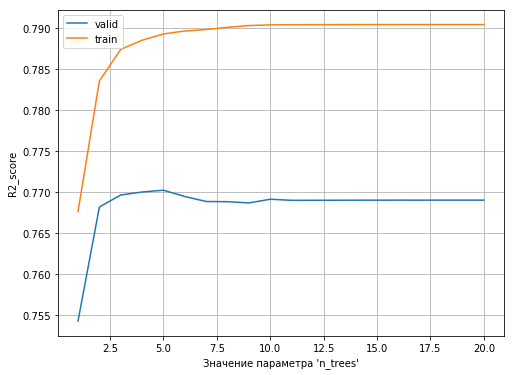

In [11]:
plot_r2_model(x_train_reg, y_train_reg, x_valid_reg, y_valid_reg, GradBoostRegressor, 'n_trees', np.arange(1, 21))

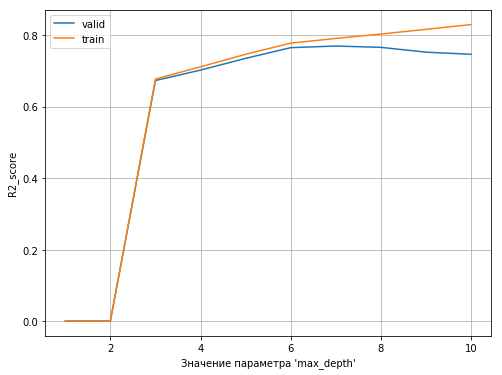

In [12]:
plot_r2_model(x_train_reg, y_train_reg, x_valid_reg, y_valid_reg, GradBoostRegressor, 'max_depth', np.arange(1, 11))

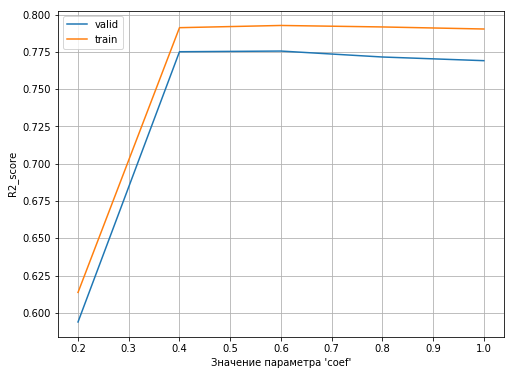

In [13]:
plot_r2_model(x_train_reg, y_train_reg, x_valid_reg, y_valid_reg, GradBoostRegressor, 'coef', np.arange(0.2, 1.1, 0.2))

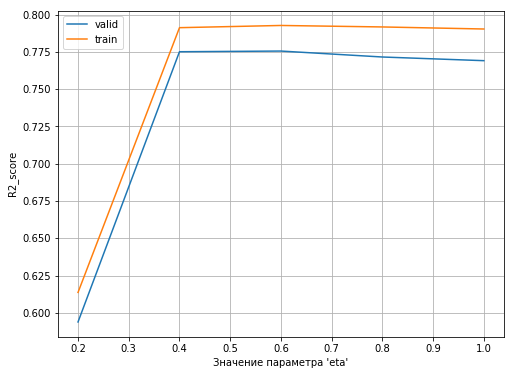

In [14]:
plot_r2_model(x_train_reg, y_train_reg, x_valid_reg, y_valid_reg, GradBoostRegressor, 'eta', np.arange(0.2, 1.1, 0.2))

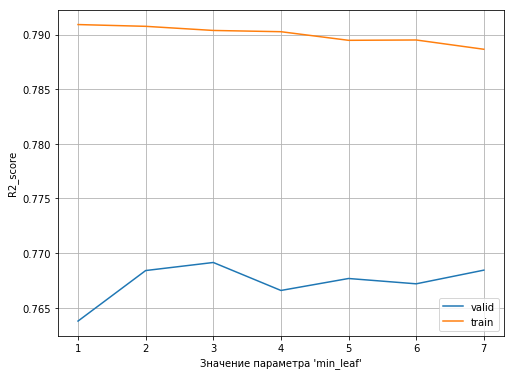

In [15]:
plot_r2_model(x_train_reg, y_train_reg, x_valid_reg, y_valid_reg, GradBoostRegressor, 'min_leaf', np.arange(1, 8))

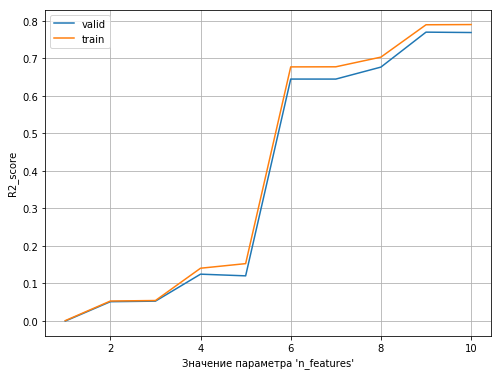

In [16]:
plot_r2_model(x_train_reg, y_train_reg, x_valid_reg, y_valid_reg, GradBoostRegressor, 'n_features', np.arange(1, 11))

In [17]:
gbr = GradBoostRegressor(n_trees=10, max_depth=7, coef=1, eta=1, min_leaf=4)
gbr.fit(x_train_reg, y_train_reg)
train_pred_reg = gbr.predict(x_train_reg)
valid_pred_reg = gbr.predict(x_valid_reg)

In [19]:
print(r2_score_(train_pred_reg, y_train_reg))
print(r2_score_(valid_pred_reg, y_valid_reg))

0.7361061557997676
0.7074526706885527


In [20]:
gbr.fit(train_x_reg, train_y_reg)
predictions_reg = gbr.predict(test_reg)

In [21]:
submission_reg = pd.read_csv('Регрессия/submission_example.csv')
submission_reg[target_reg] = predictions_reg

In [22]:
submission_reg.to_csv('Регрессия/submission.csv', sep=',', index=None, encoding='utf-8')